## Imports

In [1]:
#Library imports
import re
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2


#User Created functions

from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/setup_functions.py:22: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

In [5]:
train_data = np.load("data/kuzushiji49/train/k49-train-imgs.npz")['arr_0']
train_labels = np.load("data/kuzushiji49/train/k49-train-labels.npz")['arr_0']
test_data = np.load("data/kuzushiji49/test/k49-test-imgs.npz")['arr_0']
test_labels = np.load("data/kuzushiji49/test/k49-test-labels.npz")['arr_0']
classmap = pd.read_csv("data/kuzushiji49/k49_classmap.csv")

## EDA

In [7]:
full_value_counts(pd.DataFrame(train_labels), 0)

There are 49 unique values with 0 nan values making up 0.0%
6000-24 --2.58%
6000-27 --2.58%
6000-47 --2.58%
6000-21 --2.58%
6000-20 --2.58%
6000-19 --2.58%
6000-18 --2.58%
6000-17 --2.58%
6000-15 --2.58%
6000-12 --2.58%
6000-11 --2.58%
6000-10 --2.58%
6000-9 --2.58%
6000-7 --2.58%
6000-6 --2.58%
6000-5 --2.58%
6000-4 --2.58%
6000-2 --2.58%
6000-1 --2.58%
6000-25 --2.58%
6000-0 --2.58%
6000-28 --2.58%
6000-46 --2.58%
6000-30 --2.58%
6000-41 --2.58%
6000-40 --2.58%
6000-39 --2.58%
6000-38 --2.58%
6000-34 --2.58%
6000-35 --2.58%
6000-37 --2.58%
5132-26 --2.21%
4714-8 --2.03%
4165-13 --1.79%
3867-14 --1.66%
3523-48 --1.52%
3394-33 --1.46%
3060-31 --1.32%
2565-16 --1.10%
2451-23 --1.05%
2397-43 --1.03%
2139-42 --0.92%
2063-22 --0.89%
1993-29 --0.86%
1718-32 --0.74%
1598-36 --0.69%
777-3 --0.33%
417-44 --0.18%
392-45 --0.17%


In [4]:
classmap

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お
5,5,U+304B,か
6,6,U+304D,き
7,7,U+304F,く
8,8,U+3051,け
9,9,U+3053,こ


In [37]:
imgs = [array_to_img(test_data[30].reshape([28,28,1])), "test", array_to_img(test_data[31].reshape([28,28,1]))]
display(*imgs)

'test'

In [20]:
classmap.iloc[test_labels[30]]

index            29
codepoint    U+307B
char              ほ
Name: 29, dtype: object

In [6]:
counts = pd.Series(train_labels).reset_index().groupby(0).count().reset_index().rename(columns={0:"index", "index":"count"})
counts = counts.merge(classmap, how="left", on="index")

In [7]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [14]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

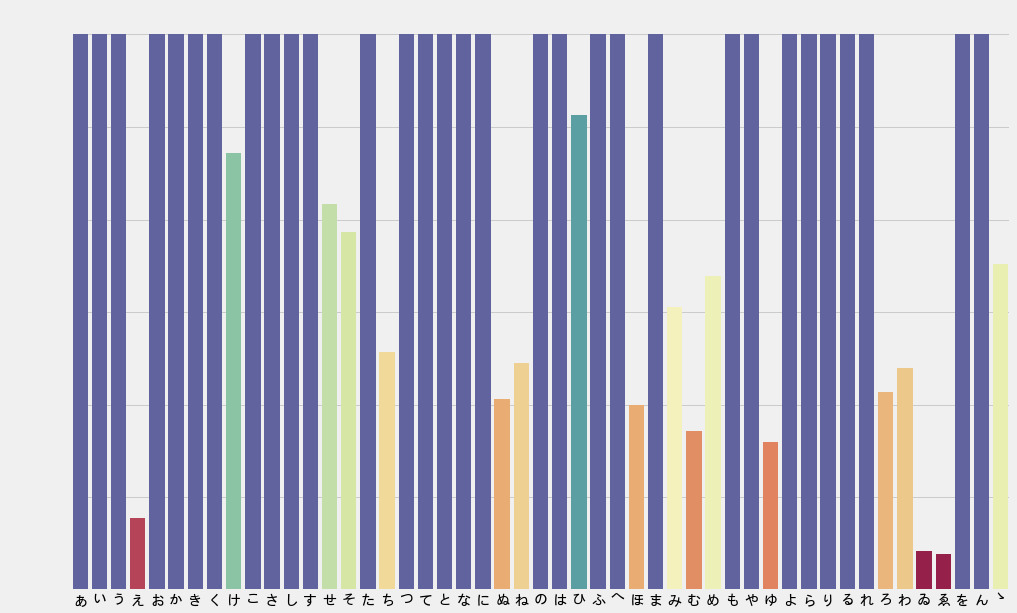

In [42]:
warnings.filterwarnings('ignore')
fig, ax = common_plot_setup(style="fivethirtyeight", font="Droid Sans Japanese")
sns.barplot("char", "count", data=counts, ax=ax, palette=colors_from_values(counts["count"], 'Spectral'))
plt.show()
warnings.filterwarnings('default')

In [18]:
array_to_img(test_data[40].reshape([28,28,1]))

Label: 19


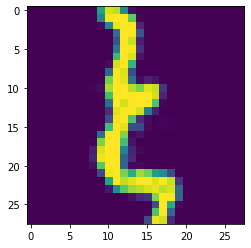

In [23]:
sample_image = test_data[0]
sample_label = test_labels[0]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

## Preprocessing

In [9]:
def preprocess_raster_common(array, bits=8):
    X = array.copy()
    X = color_values_to_float(X, bits)
    return images_to_1d(X)

def preprocess_raster_pipeline(array, labels, bits=8, resample=None, random_state=None, test_size=None):
    X = preprocess_raster_common(array, bits)
    y = labels.copy()
    
    if test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_train, y_train = preprocess_raster_resampling(X_train, y_train, resample, random_state)
        return X_train, X_test, to_categorical(y_train), to_categorical(y_test)
    else:
        X, y = preprocess_raster_resampling(X, y, resample, random_state)
        return X, to_categorical(y)

In [26]:
X_train, X_val, y_train, y_val = preprocess_raster_pipeline(train_data, train_labels, resample="smote", test_size=.2, random_state = SEED)
X_test, y_test = preprocess_raster_pipeline(test_data, test_labels)

performing SMOTE
Ignoring class imbalances


In [30]:
y_train.shape

(239659, 49)

## Modeling

### Iteration1

In [7]:
model1 = Sequential()
model1.add(Dense(64, "tanh", input_shape=(784,)))
model1.add(Dense(49, activation='softmax'))

In [8]:
model1.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [9]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 49)                3185      
Total params: 53,425
Trainable params: 53,425
Non-trainable params: 0
_________________________________________________________________


In [10]:
results, test_metrics = [], []
for i in np.arange(0,6):
    result = model1.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))
    test_metric = model1.evaluate(X_test, y_test)
    results.append(result)
    test_metrics.append(test_metric)
    model1.save(f"model_backups/model1_{i}")

Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 25us/sample - loss: 2.3792 - accuracy: 0.4759 - val_loss: 1.7708 - val_accuracy: 0.5959
Epoch 2/5
235200/235200 [==============================] - 6s 25us/sample - loss: 1.6025 - accuracy: 0.6256 - val_loss: 1.4835 - val_accuracy: 0.6444
Epoch 3/5
235200/235200 [==============================] - 6s 25us/sample - loss: 1.4110 - accuracy: 0.6603 - val_loss: 1.3522 - val_accuracy: 0.6708
Epoch 4/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.3046 - accuracy: 0.6831 - val_loss: 1.2666 - val_accuracy: 0.6897
Epoch 5/5
38547/38547 [==============================] - 1s 32us/sample - loss: 1.8005 - accuracy: 0.5625
Test Loss: 1.8004744404264748, Test Accuracy: 0.5624821782112122
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_backups/model10/assets
Train on 235200 samples, validate

In [9]:
plot_keras_fit_history(results, 0, common_plot_kwargs={"style": "fivethirtyeight"})

NameError: name 'results' is not defined

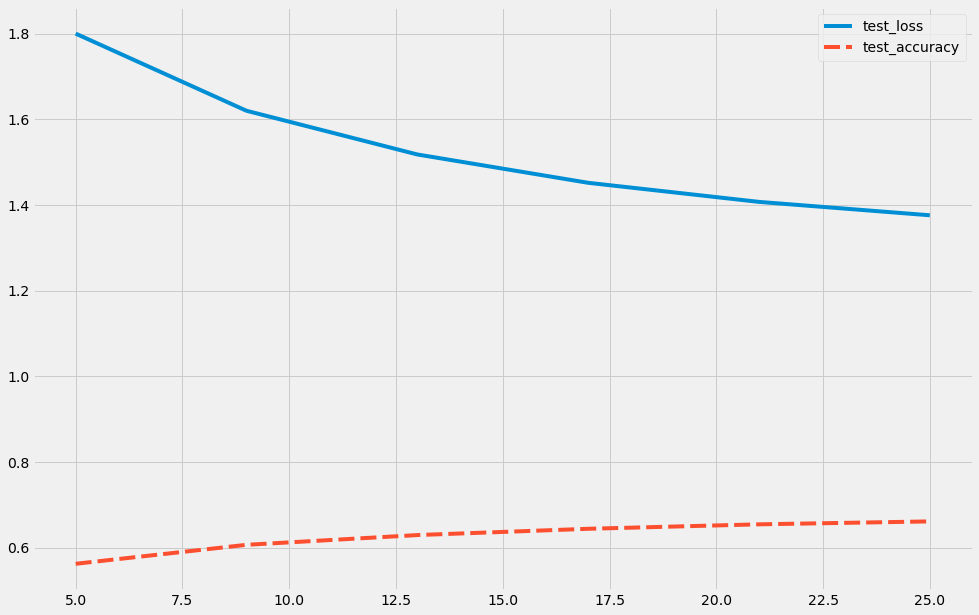

,test_loss,test_accuracy
5,1.800474,0.562482
9,1.620321,0.606792
13,1.518259,0.629543
17,1.452098,0.644227
21,1.407530,0.654629
25,1.376256,0.661452


In [12]:
plot_keras_test_evaluation(test_metrics, 5, 4, common_plot_kwargs={"style": "fivethirtyeight"})

### Iteration2

In [17]:
model2 = Sequential()
model2.add(Dense(64, "tanh", input_shape=(784,)))
model2.add(Dense(56, activation='tanh'))
model2.add(Dense(49, activation='softmax'))
model2.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model2.summary()

In [20]:
results2, test_metrics2 = [], []
for i in np.arange(0,6):
    result = model2.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))
    test_metric = model2.evaluate(X_test, y_test)
    results2.append(result)
    test_metrics2.append(test_metric)
    model2.save(f"model_backups/model2_{i}")

Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 25us/sample - loss: 2.5061 - accuracy: 0.4416 - val_loss: 1.8277 - val_accuracy: 0.5837
Epoch 2/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.6169 - accuracy: 0.6211 - val_loss: 1.4733 - val_accuracy: 0.6459
Epoch 3/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.3774 - accuracy: 0.6660 - val_loss: 1.3051 - val_accuracy: 0.6801
Epoch 4/5
235200/235200 [==============================] - 6s 24us/sample - loss: 1.2390 - accuracy: 0.6953 - val_loss: 1.1944 - val_accuracy: 0.7057
Epoch 5/5
38547/38547 [==============================] - 1s 32us/sample - loss: 1.7071 - accuracy: 0.5826
Test Loss: 1.7070775213886564, Test Accuracy: 0.582587480545044
INFO:tensorflow:Assets written to: model_backups/model2_0/assets
Train on 235200 samples, validate on 58800 samples
Epoch 1/5
235200/235200 [==============================] - 6s 2

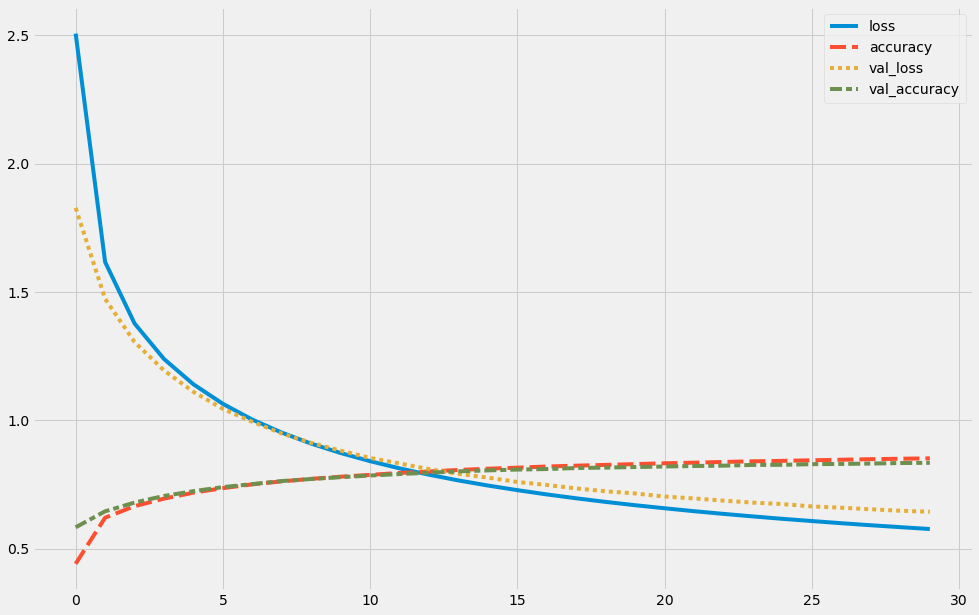

,loss,accuracy,val_loss,val_accuracy
0,2.506141,0.441586,1.827728,0.583656
1,1.616945,0.621084,1.473286,0.645935
2,1.377370,0.666008,1.305065,0.680085
3,1.239048,0.695293,1.194392,0.705748
4,1.140400,0.718588,1.111033,0.724439
5,1.064400,0.736080,1.044772,0.740204
6,1.002901,0.750940,0.994356,0.751990
7,0.952358,0.762509,0.948813,0.763776
8,0.909368,0.772351,0.912475,0.771752
9,0.872818,0.780795,0.882026,0.778929


In [25]:
plot_keras_fit_history(results2, 0, common_plot_kwargs={"style": "fivethirtyeight"})

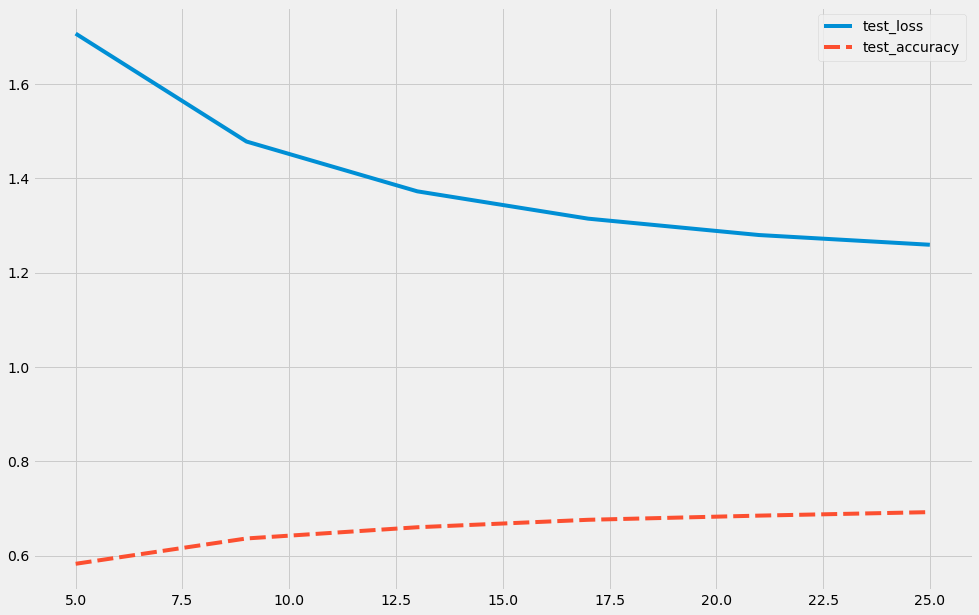

,test_loss,test_accuracy
5,1.707078,0.582587
9,1.478183,0.636314
13,1.372544,0.660103
17,1.314594,0.675902
21,1.279869,0.684748
25,1.259240,0.692168


In [26]:
plot_keras_test_evaluation(test_metrics2, 5, 4, common_plot_kwargs={"style": "fivethirtyeight"})

### Iteration3

In [14]:
model3 = Sequential()
model3.add(Dense(64, "relu", input_shape=(784,)))
model3.add(Dense(56, activation='relu'))
model3.add(Dense(49, activation='softmax'))
model3.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 56)                3640      
_________________________________________________________________
dense_8 (Dense)              (None, 49)                2793      
Total params: 56,673
Trainable params: 56,673
Non-trainable params: 0
_________________________________________________________________


In [17]:
backups = ModelCheckpoint("model_backups/model3-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results = model3.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[backups, stopping])

Train on 239659 samples, validate on 46473 samples
Epoch 1/200
239659/239659 [==============================] - 7s 30us/sample - loss: 2.3662 - accuracy: 0.4338 - val_loss: 1.6167 - val_accuracy: 0.6022
Epoch 2/200
239659/239659 [==============================] - 7s 29us/sample - loss: 1.4002 - accuracy: 0.6534 - val_loss: 1.3335 - val_accuracy: 0.6646
Epoch 3/200
239659/239659 [==============================] - 7s 29us/sample - loss: 1.1885 - accuracy: 0.7030 - val_loss: 1.1803 - val_accuracy: 0.7016
Epoch 4/200
239659/239659 [==============================] - 7s 29us/sample - loss: 1.0551 - accuracy: 0.7332 - val_loss: 1.0810 - val_accuracy: 0.7254
Epoch 5/200
239659/239659 [==============================] - 7s 28us/sample - loss: 0.9587 - accuracy: 0.7572 - val_loss: 1.0031 - val_accuracy: 0.7446
Epoch 6/200
239659/239659 [==============================] - 7s 29us/sample - loss: 0.8845 - accuracy: 0.7746 - val_loss: 0.9417 - val_accuracy: 0.7595
Epoch 7/200
239659/239659 [==========

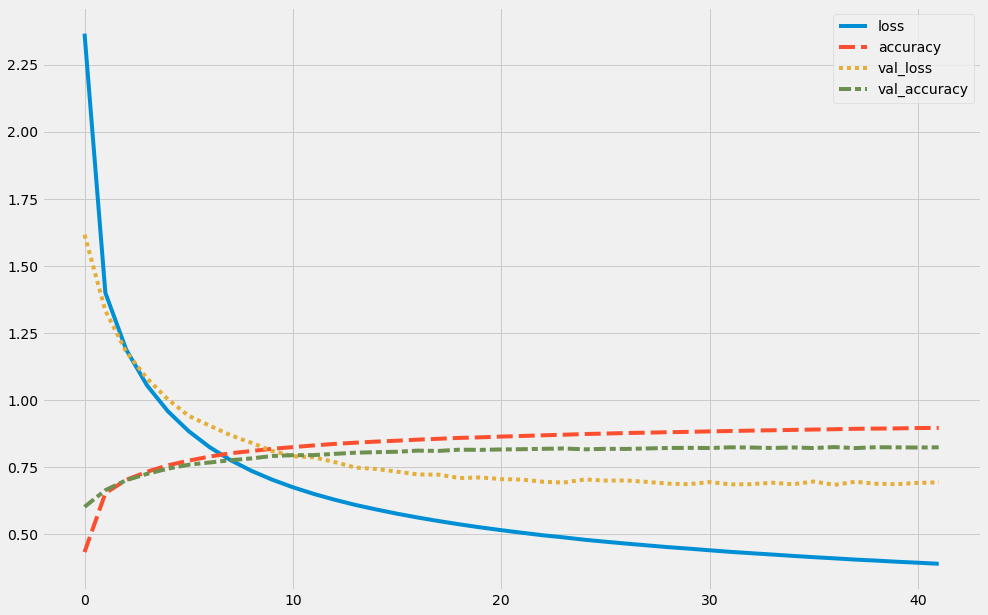

,loss,accuracy,val_loss,val_accuracy
0,2.366226,0.433804,1.616739,0.602156
1,1.400208,0.653374,1.333480,0.664579
2,1.188491,0.703045,1.180299,0.701633
3,1.055068,0.733204,1.080968,0.725410
4,0.958654,0.757172,1.003083,0.744626
5,0.884458,0.774626,0.941712,0.759452
6,0.825039,0.789718,0.905263,0.767628
7,0.776843,0.802044,0.869674,0.776214
8,0.736996,0.810431,0.841380,0.782842
9,0.703898,0.818651,0.810547,0.791750


In [18]:
plot_keras_fit_history(results, 0, common_plot_kwargs={"style": "fivethirtyeight"})

### Iteration4

In [7]:
lambda_coef = .0005
model4 = Sequential()
model4.add(Dense(64, "relu", input_shape=(784,),kernel_regularizer=l2(lambda_coef)))
model4.add(Dense(56, activation='relu', kernel_regularizer=l2(lambda_coef)))
model4.add(Dense(49, activation='softmax'))
model4.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 56)                3640      
_________________________________________________________________
dense_2 (Dense)              (None, 49)                2793      
Total params: 56,673
Trainable params: 56,673
Non-trainable params: 0
_________________________________________________________________


In [12]:
backups4 = ModelCheckpoint("model_backups/model4-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results4 = model4.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[backups4, stopping])

Train on 239659 samples, validate on 46473 samples
Epoch 1/200
238784/239659 [============================>.] - ETA: 0s - loss: 2.4887 - accuracy: 0.4219WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_backups/model4-01/assets
239659/239659 [==============================] - 8s 32us/sample - loss: 2.4858 - accuracy: 0.4225 - val_loss: 1.7223 - val_accuracy: 0.6015
Epoch 2/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.4996 - accuracy: 0.6548 - val_loss: 1.4421 - val_accuracy: 0.6645
Epoch 3/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.3043 - accuracy: 0.7036 - val_loss: 1.303

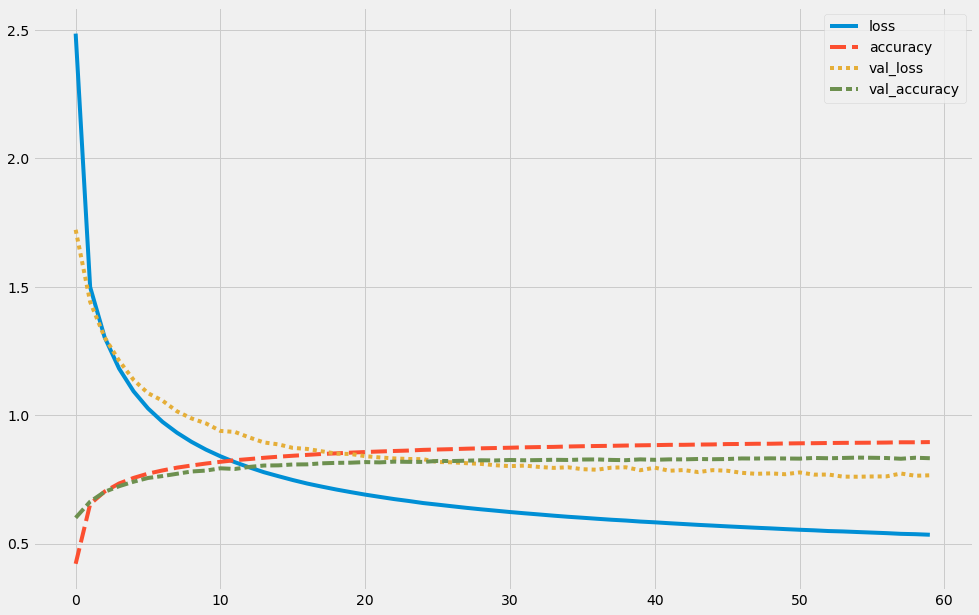

,loss,accuracy,val_loss,val_accuracy
0,2.485786,0.422504,1.722314,0.601532
1,1.499601,0.654818,1.442077,0.664450
2,1.304344,0.703579,1.303468,0.702537
3,1.182274,0.735028,1.212840,0.724378
4,1.093769,0.756700,1.138251,0.741958
5,1.027001,0.773391,1.086356,0.756525
6,0.974822,0.785791,1.057353,0.763949
7,0.932657,0.796703,1.015807,0.772814
8,0.897134,0.804977,0.988306,0.781680
9,0.866838,0.812692,0.968803,0.785252


In [13]:
plot_keras_fit_history(results4, 0, common_plot_kwargs={"style": "fivethirtyeight"})

### Iteration5

In [16]:
lambda_coef = .0005
model5 = Sequential()
model5.add(Dense(64, "relu", input_shape=(784,),kernel_regularizer=l1(lambda_coef)))
model5.add(Dense(56, activation='relu', kernel_regularizer=l1(lambda_coef)))
model5.add(Dense(49, activation='softmax'))
model5.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 56)                3640      
_________________________________________________________________
dense_8 (Dense)              (None, 49)                2793      
Total params: 56,673
Trainable params: 56,673
Non-trainable params: 0
_________________________________________________________________


In [17]:
backups5 = ModelCheckpoint("model_backups/model5-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results4 = model5.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[backups5, stopping])

Train on 239659 samples, validate on 46473 samples
Epoch 1/200
239659/239659 [==============================] - 7s 31us/sample - loss: 3.4921 - accuracy: 0.4285 - val_loss: 2.6146 - val_accuracy: 0.5955
Epoch 2/200
239659/239659 [==============================] - 7s 31us/sample - loss: 2.2904 - accuracy: 0.6424 - val_loss: 2.1347 - val_accuracy: 0.6483
Epoch 3/200
239659/239659 [==============================] - 8s 32us/sample - loss: 1.9475 - accuracy: 0.6790 - val_loss: 1.8967 - val_accuracy: 0.6745
Epoch 4/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.7656 - accuracy: 0.6979 - val_loss: 1.7698 - val_accuracy: 0.6872
Epoch 5/200
239659/239659 [==============================] - 7s 31us/sample - loss: 1.6571 - accuracy: 0.7132 - val_loss: 1.6817 - val_accuracy: 0.6989
Epoch 6/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.5830 - accuracy: 0.7261 - val_loss: 1.6160 - val_accuracy: 0.7134
Epoch 7/200
239659/239659 [==========

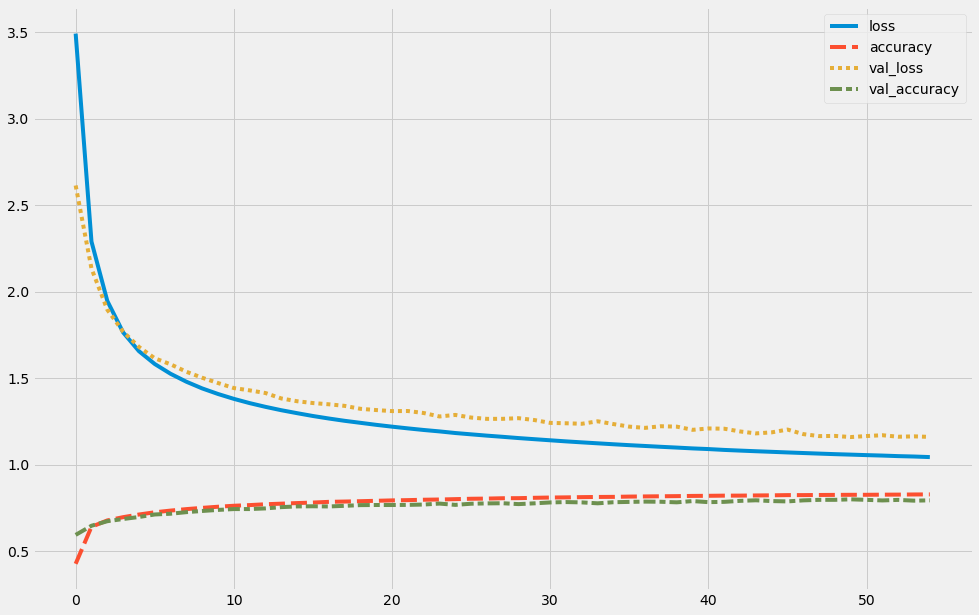

,loss,accuracy,val_loss,val_accuracy
0,3.492110,0.428484,2.614640,0.595464
1,2.290366,0.642396,2.134748,0.648269
2,1.947537,0.679006,1.896675,0.674499
3,1.765591,0.697900,1.769779,0.687195
4,1.657145,0.713209,1.681727,0.698900
5,1.582967,0.726094,1.616040,0.713425
6,1.526415,0.735887,1.581151,0.717750
7,1.480530,0.744437,1.538219,0.726917
8,1.441827,0.751643,1.503496,0.733695
9,1.409663,0.758177,1.473006,0.739806


In [19]:
plot_keras_fit_history(results4, 0, common_plot_kwargs={"style": "fivethirtyeight"})

### Iteration6

In [23]:
lambda_coef = .0005
model6 = Sequential()
model6.add(Dense(64, "relu", input_shape=(784,),kernel_regularizer=l2(lambda_coef)))
model6.add(Dropout(.2))
model6.add(Dense(56, activation='relu', kernel_regularizer=l2(lambda_coef)))
model6.add(Dropout(.2))
model6.add(Dense(49, activation='softmax'))
model6.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 56)                3640      
_________________________________________________________________
dropout_4 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 49)                2793      
Total params: 56,673
Trainable params: 56,673
Non-trainable params: 0
_________________________________________________________________


In [24]:
backups6 = ModelCheckpoint("model_backups/model6-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results6 = model6.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[backups6, stopping])

Train on 239659 samples, validate on 46473 samples
Epoch 1/200
239659/239659 [==============================] - 8s 32us/sample - loss: 2.9932 - accuracy: 0.2600 - val_loss: 2.0185 - val_accuracy: 0.5451
Epoch 2/200
239659/239659 [==============================] - 7s 31us/sample - loss: 2.0952 - accuracy: 0.4836 - val_loss: 1.6524 - val_accuracy: 0.6128
Epoch 3/200
239659/239659 [==============================] - 8s 31us/sample - loss: 1.8515 - accuracy: 0.5449 - val_loss: 1.4881 - val_accuracy: 0.6495
Epoch 4/200
239659/239659 [==============================] - 8s 32us/sample - loss: 1.7238 - accuracy: 0.5750 - val_loss: 1.3993 - val_accuracy: 0.6707
Epoch 5/200
239659/239659 [==============================] - 8s 32us/sample - loss: 1.6399 - accuracy: 0.5965 - val_loss: 1.3267 - val_accuracy: 0.6877
Epoch 6/200
239659/239659 [==============================] - 8s 31us/sample - loss: 1.5769 - accuracy: 0.6126 - val_loss: 1.2714 - val_accuracy: 0.7024
Epoch 7/200
239659/239659 [==========

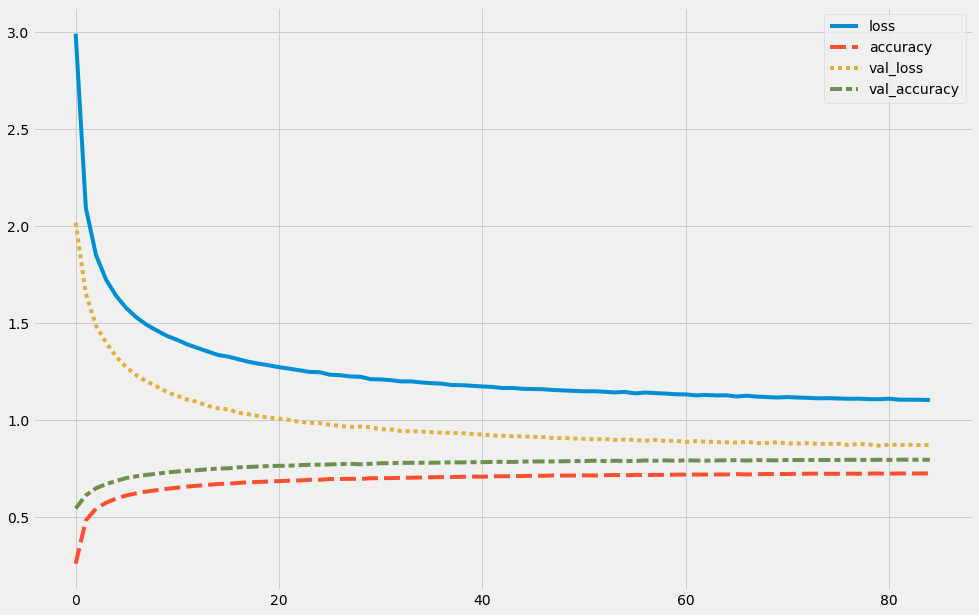

,loss,accuracy,val_loss,val_accuracy
0,2.993191,0.260049,2.018544,0.545134
1,2.095166,0.483637,1.652422,0.612786
2,1.851498,0.544945,1.488123,0.649495
3,1.723805,0.574967,1.399270,0.670734
4,1.639889,0.596527,1.326739,0.687733
...,...,...,...,...
80,1.111260,0.724442,0.874692,0.795602
81,1.106011,0.725560,0.872601,0.796807
82,1.105892,0.725877,0.873599,0.796936
83,1.105385,0.725372,0.872187,0.796247


In [25]:
plot_keras_fit_history(results6, 0, common_plot_kwargs={"style": "fivethirtyeight"})

### Iteration7

In [27]:
lambda_coef = .0005
model7 = Sequential()
model7.add(Dense(64, "relu", input_shape=(784,),kernel_regularizer=l2(lambda_coef)))
model7.add(Dense(56, activation='relu', kernel_regularizer=l2(lambda_coef)))
model7.add(Dense(49, activation='softmax'))
model7.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])
model7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_16 (Dense)             (None, 56)                3640      
_________________________________________________________________
dense_17 (Dense)             (None, 49)                2793      
Total params: 56,673
Trainable params: 56,673
Non-trainable params: 0
_________________________________________________________________


In [28]:
backups7 = ModelCheckpoint("model_backups/model7-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)

results7 = model7.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[backups7, stopping])

Train on 239659 samples, validate on 46473 samples
Epoch 1/200
239659/239659 [==============================] - 7s 30us/sample - loss: 2.5213 - accuracy: 0.4223 - val_loss: 1.7521 - val_accuracy: 0.5971
Epoch 2/200
239659/239659 [==============================] - 7s 29us/sample - loss: 1.4892 - accuracy: 0.6607 - val_loss: 1.4633 - val_accuracy: 0.6631
Epoch 3/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.2845 - accuracy: 0.7088 - val_loss: 1.3081 - val_accuracy: 0.7017
Epoch 4/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.1607 - accuracy: 0.7395 - val_loss: 1.2203 - val_accuracy: 0.7233
Epoch 5/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.0706 - accuracy: 0.7622 - val_loss: 1.1359 - val_accuracy: 0.7431
Epoch 6/200
239659/239659 [==============================] - 7s 30us/sample - loss: 1.0022 - accuracy: 0.7798 - val_loss: 1.0789 - val_accuracy: 0.7581
Epoch 7/200
239659/239659 [==========

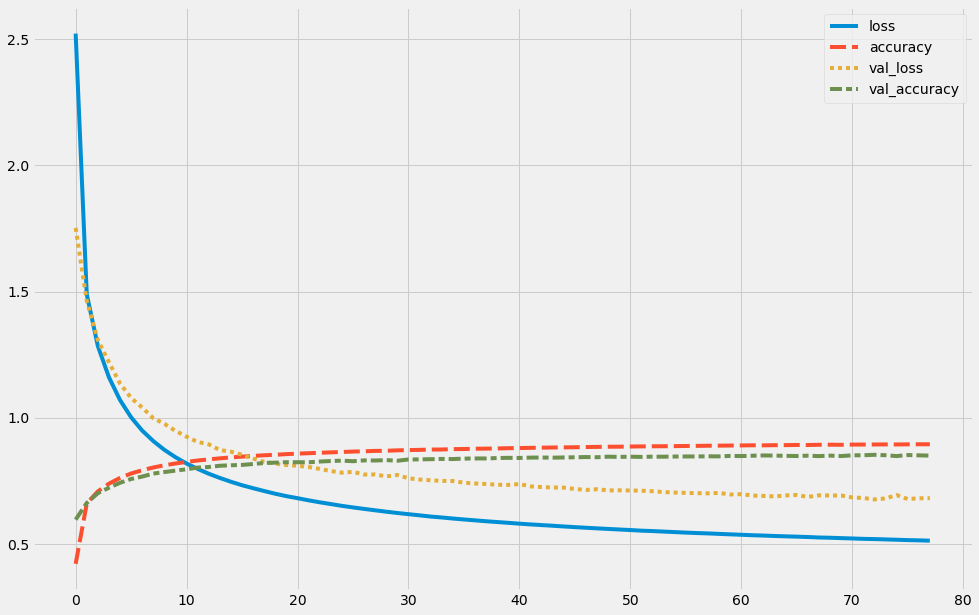

,loss,accuracy,val_loss,val_accuracy
0,2.521285,0.422292,1.752099,0.597121
1,1.489227,0.660685,1.463295,0.663116
2,1.284496,0.708849,1.308140,0.701719
3,1.160700,0.739467,1.220334,0.723302
4,1.070565,0.762208,1.135855,0.743055
...,...,...,...,...
73,0.518787,0.894913,0.680870,0.852108
74,0.517506,0.894755,0.694416,0.848708
75,0.516088,0.895143,0.678757,0.852796
76,0.515108,0.895472,0.681606,0.851591


In [29]:
plot_keras_fit_history(results7, 0, common_plot_kwargs={"style": "fivethirtyeight"})